In [1]:
import os
import sys
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', markersize=10)

In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model_name = "resnet18"
model = torch.hub.load('pytorch/vision:v0.6.0', model_name, pretrained=True)
print("Using device:", device)
model.to(device)
model.eval()

Using cache found in /Users/quyenlinhta/.cache/torch/hub/pytorch_vision_v0.6.0


Using device: mps


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
def extract_features_from_frame(frame, model, transform, device):
    image = Image.fromarray(frame).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image)
    return features.cpu().numpy().flatten()


def process_npy_files(input_dir, output_dir, model, transform, device):
    count_files = len([file for file in os.listdir(input_dir) if file.endswith('_frames.npy')])
    progress = tqdm(os.listdir(input_dir), total=count_files, desc="Processing")
    for subject_file in progress:
        if subject_file.endswith('_frames.npy'):
            subject = subject_file.replace('_frames.npy', '')
            frames_path = os.path.join(input_dir, subject_file)
            frames = np.load(frames_path)
            features_list = []
            for frame in frames:
                features = extract_features_from_frame(frame, model, transform, device)
                features_list.append(features)
            features_array = np.array(features_list)
            np.save(os.path.join(output_dir, f"{subject}_features.npy"), features_array)
            progress.set_description(f"Processed {subject}")

In [48]:
image_dir = '../processed/'
output_dir = '../features/'
os.makedirs(output_dir, exist_ok=True)

In [49]:
process_npy_files(image_dir, output_dir, model, transform, device)

Processing:   0%|          | 0/86 [00:00<?, ?it/s]

In [5]:
def load_features(subject, features_dir):
    features = np.load(os.path.join(features_dir, f"{subject}"))
    return features

In [12]:
features = {}
feature_dir = '../features/vit_base_patch16_224'
for subject in os.listdir(feature_dir):
    features[subject] = load_features(subject, feature_dir)

In [13]:
features_shape = set([features_array.shape for features_array in features.values()])
print("Features shape:", features_shape)
print("Count of feature files:", len(features))

Features shape: {(250, 151296)}
Count of feature files: 86


In [14]:
def flatten_and_pca(features):
    from sklearn.decomposition import PCA
    features_flat = features.reshape(features.shape[0], -1)
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_flat)
    return features_pca

pca = {}
for subject, features_array in features.items():
    pca[subject] = flatten_and_pca(features_array)

IndexError: index 12 is out of bounds for axis 0 with size 12

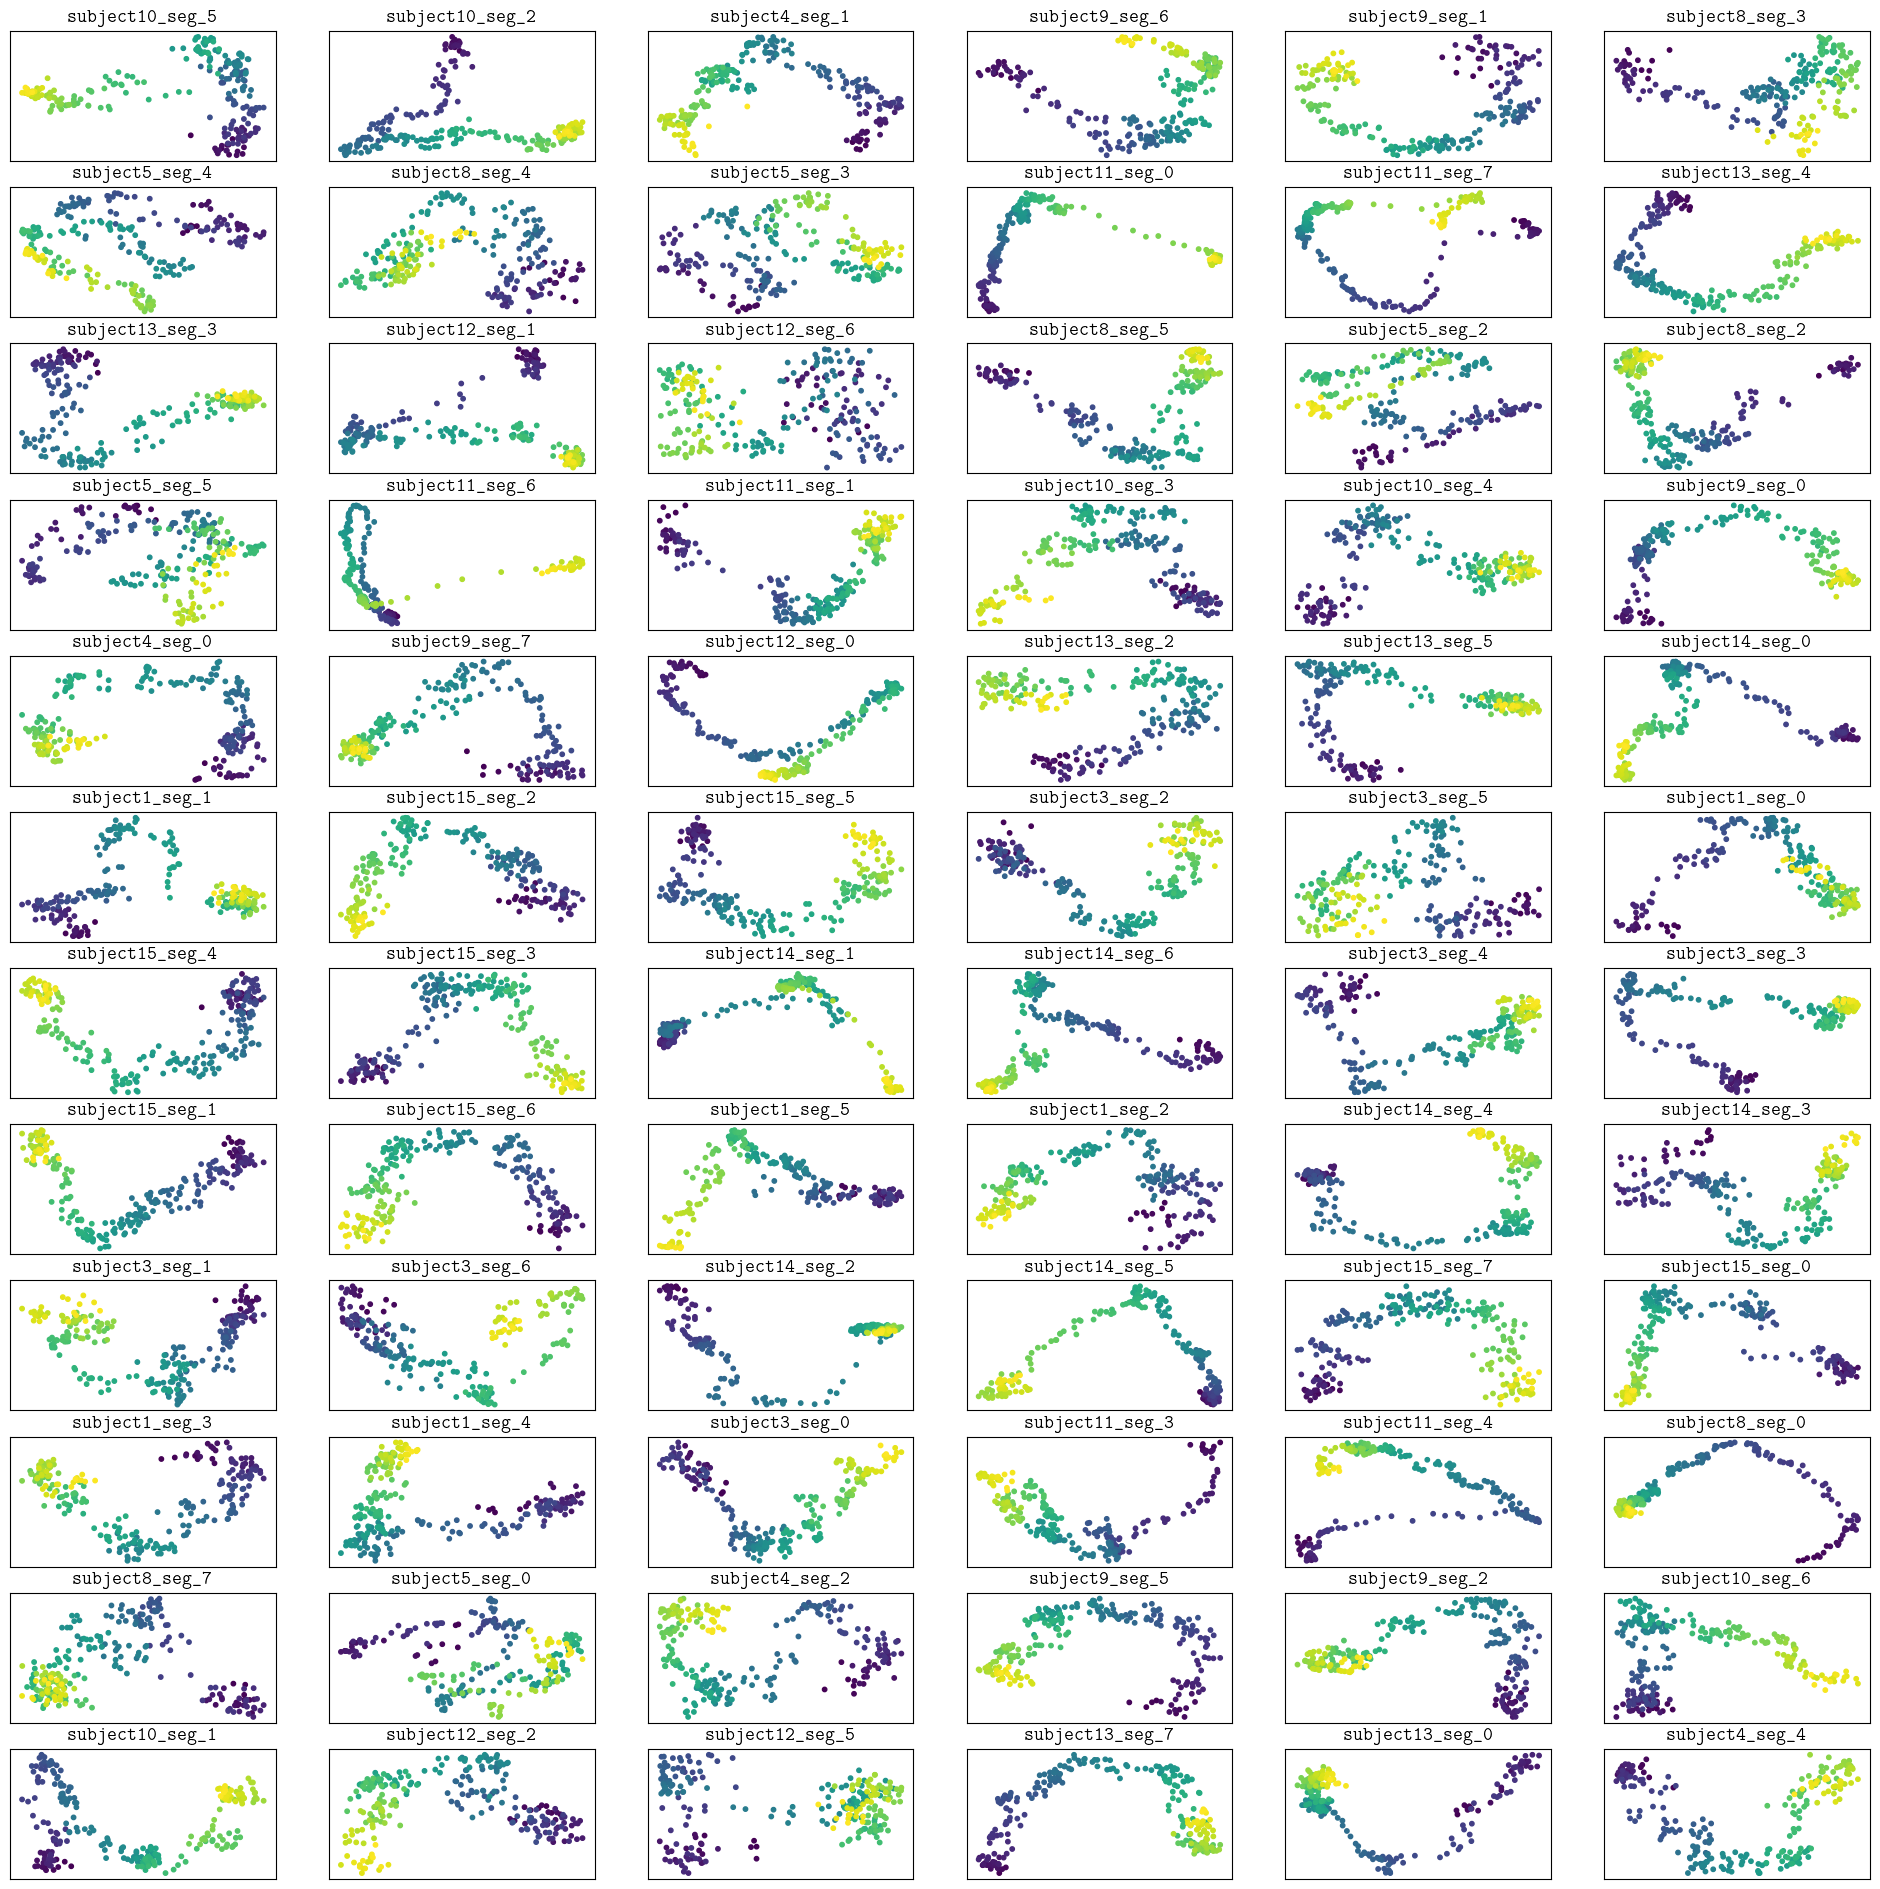

In [15]:
fig, ax = plt.subplots(12, 6, figsize=(24, 24))
cmap = plt.get_cmap('viridis')
for i, (subject, features_pca) in enumerate(pca.items()):
    row, col = i // 6, i % 6
    ax[row, col].scatter(features_pca[:, 0], features_pca[:, 1], c=np.arange(features_pca.shape[0]), cmap=cmap, s=10)
    subject_rename = subject.replace('_features.npy', '')
    ax[row, col].set_title(r"$\texttt{" + subject_rename + r"}$")
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
plt.tight_layout()
plt.savefig(f'../figures/features_pca_{model_name}.pdf', bbox_inches='tight')
plt.show()

In [2]:
path_to_signals = '../processed/'
from prettytable import PrettyTable
rPPG_signals = {}
for file in os.listdir(path_to_signals):
    if file.endswith('_gt.npy'):
        subject = file.replace('_gt.npy', '')
        signal_path = os.path.join(path_to_signals, file)
        rPPG_signal = np.load(signal_path)
        rPPG_signals[subject] = rPPG_signal
table = PrettyTable()
table.field_names = ['Subject', 'Num. Samples', 'Mean (bpm)', 'Std. Dev. (bpm)']
for subject, rPPG_signal in rPPG_signals.items():
    table.add_row([subject, rPPG_signal.size, rPPG_signal.mean(), rPPG_signal.std()])
print(table)

+-----------------+--------------+-----------------------+--------------------+
|     Subject     | Num. Samples |       Mean (bpm)      |  Std. Dev. (bpm)   |
+-----------------+--------------+-----------------------+--------------------+
|  subject9_seg_4 |     250      |    0.1916542491848    | 1.0712748921126567 |
| subject11_seg_1 |     250      |  0.11151516115955999  | 1.3719724482551503 |
|  subject1_seg_5 |     250      |  0.07709686851279995  | 1.0703467607786712 |
| subject12_seg_6 |     250      |  0.02952354834480002  | 0.9114063356618767 |
| subject15_seg_6 |     250      |  0.013036477166400004 | 0.6256109041784691 |
|  subject5_seg_2 |     250      | -0.007388341116000006 | 0.9153861734814711 |
|  subject3_seg_0 |     250      |  -0.30173705347479995 | 0.8602946942829374 |
| subject13_seg_4 |     250      |     0.071934554044    | 1.0684948146744024 |
|  subject4_seg_0 |     250      |    0.1733749353236    | 0.9838523929609709 |
| subject14_seg_4 |     250      |  0.08

IndexError: index 2 is out of bounds for axis 0 with size 2

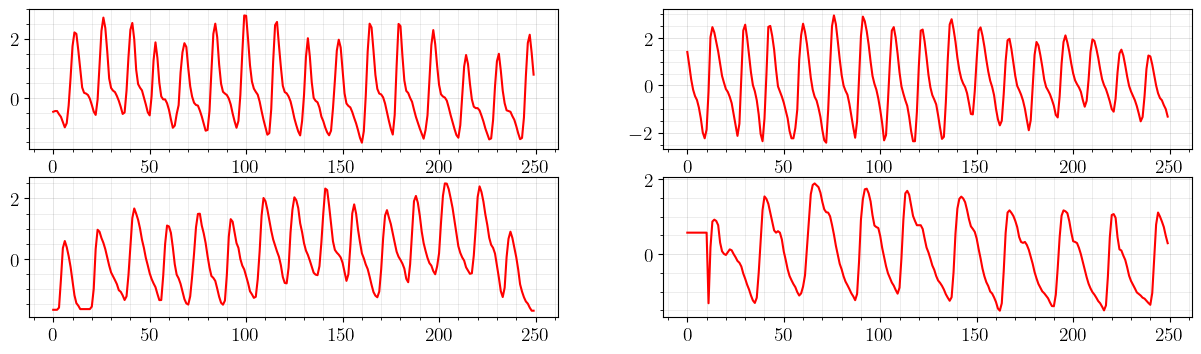

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(15, 4))
for i, (subject, heart_rate) in enumerate(rPPG_signals.items()):
    row, col = i // 2, i % 2
    ax[row, col].plot(heart_rate, label=f"rPPG Signal", color='red', linewidth=1.5)
    # ax[row, col].set_title(f"Subject: {subject} - rPPG Signal")
    ax[row, col].minorticks_on()
    ax[row, col].grid(which='major', linestyle='-', linewidth='0.5', color='grey', zorder=0, alpha=0.3)
    ax[row, col].grid(which='minor', linestyle='-', linewidth='0.5', color='gray', zorder=0, alpha=0.2)
plt.tight_layout()
plt.savefig(f'../figures/heart_rate.pdf', bbox_inches='tight')
plt.show()

In [7]:
path = '../processed/subject1_seg_1_frames.npy'
frames = np.load(path)

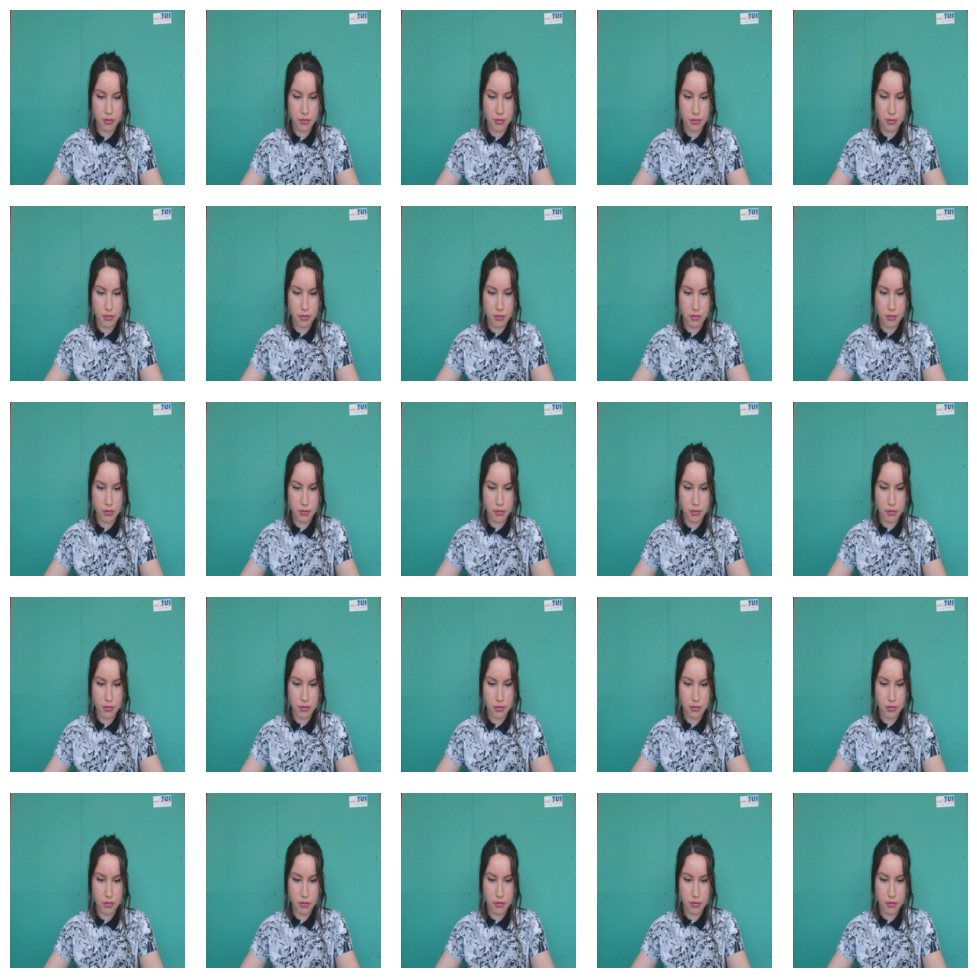

In [8]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    row, col = i // 5, i % 5
    ax[row, col].imshow(frames[i])
    ax[row, col].axis('off')
plt.tight_layout()
plt.savefig(f'../figures/frames.pdf', bbox_inches='tight')
plt.show()

In [16]:
model_path = '../saved_models/rnn_model_vit_base_patch16_224_1000_10_1e-05.pt'
model = torch.load(model_path)
model.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [17]:
# Pick a random subject feature for prediction
subject = '../features/vit_base_patch16_224/subject15_seg_7_features.npy'
ground_truth = '../processed/subject15_seg_7_gt.npy'

features = np.load(subject)
features_flat = features.reshape(features.shape[0], -1)
features_pca = pca['subject15_seg_7_features.npy']